<a href="https://www.kaggle.com/code/lizaro/notebook93d16b034d?scriptVersionId=164754438" target="_blank"><img align="left" alt="Kaggle" title="Open in Kaggle" src="https://kaggle.com/static/images/open-in-kaggle.svg"></a>

# Classification of watercolor/oil paintings

Deployed: https://huggingface.co/spaces/PrBee/space1

In [1]:
!pip install -Uqq fastai duckduckgo_search
!pip install torchmetrics

In [2]:
from fastai.vision.all import *
from duckduckgo_search import DDGS
from fastcore.all import *
from fastdownload import download_url
from PIL import Image
from time import sleep
from os import listdir
from torch import tensor
from torchmetrics.classification import BinaryConfusionMatrix
from sklearn.model_selection import train_test_split

In [3]:
def search_images(term, max_images=40):
    print(f"Searching for '{term}'")
    with DDGS() as ddgs:
        search_results = ddgs.images(keywords=term)
        image_urls = [next(search_results).get("image") for _ in range(max_images)]
        return image_urls

Download images, split to train and test sets

Grouped by genre, since it might be correlated with choise of matirial. (Bigger part of landscapes in watercolor)

In [4]:
searches = 'watercolor','oil'
genres = 'animal', 'portrait', 'landscape', 'still life'
path = Path('oil_or_watercolor')

for o in searches:
    for g in genres:        
        dest = (path/g/o)
        dest_test = Path('test')/o
        dest.mkdir(exist_ok=True, parents=True)
        dest_test.mkdir(exist_ok=True, parents=True)
        urls=search_images(f'{o} {g} painting',max_images=50)
        urls_train, urls_test = train_test_split(urls,test_size=0.2)
        download_images(dest, urls=urls_train)
        download_images(dest_test, urls=urls_test)
        sleep(1)

Searching for 'watercolor animal painting'
Searching for 'watercolor portrait painting'
Searching for 'watercolor landscape painting'
Searching for 'watercolor still life painting'
Searching for 'oil animal painting'
Searching for 'oil portrait painting'
Searching for 'oil landscape painting'
Searching for 'oil still life painting'


In [5]:
failed = verify_images(get_image_files(path))
print([parent_label(x) for x in failed].count('watercolor'))
print([parent_label(x) for x in failed].count('oil'))
failed.map(Path.unlink)
failed = verify_images(get_image_files(Path('test')))
failed.map(Path.unlink)

6
5


(#3) [None,None,None]

For test random crope used, for validation - (central) crop

In [6]:
path = Path('oil_or_watercolor')
dls = DataBlock(
    blocks=(ImageBlock, CategoryBlock), 
    get_items=get_image_files, 
    splitter=RandomSplitter(valid_pct=0.2),
    get_y=parent_label,
    item_tfms=RandomCrop(300)
).dataloaders(path, bs=32)

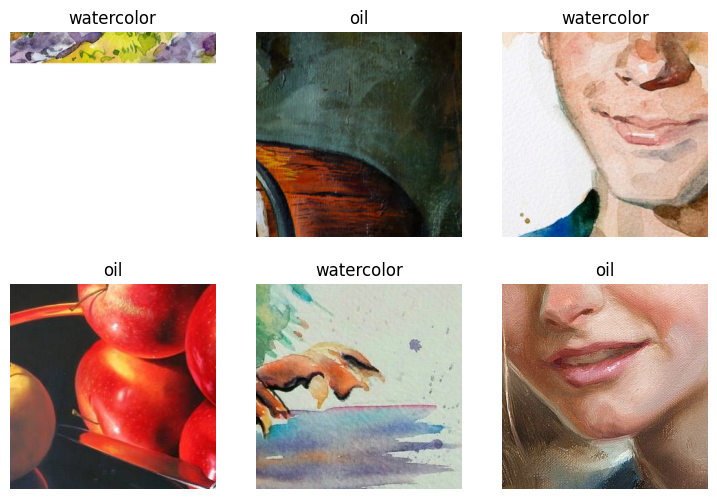

In [7]:
dls.show_batch(max_n=6)

In [8]:
learn = vision_learner(dls, resnet18, metrics=error_rate)
learn.fine_tune(3)

Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to /root/.cache/torch/hub/checkpoints/resnet18-f37072fd.pth
100%|██████████| 44.7M/44.7M [00:00<00:00, 120MB/s] 


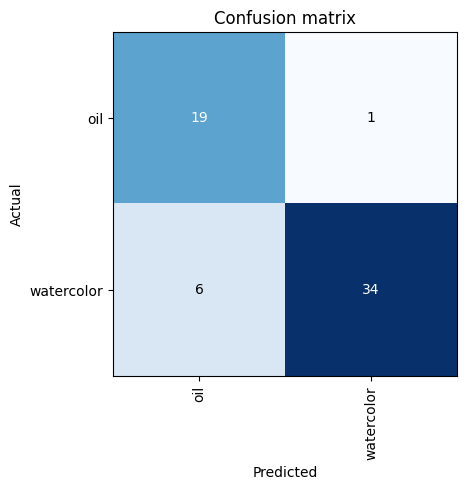

In [9]:
interp = ClassificationInterpretation.from_learner(learn)
interp.plot_confusion_matrix()

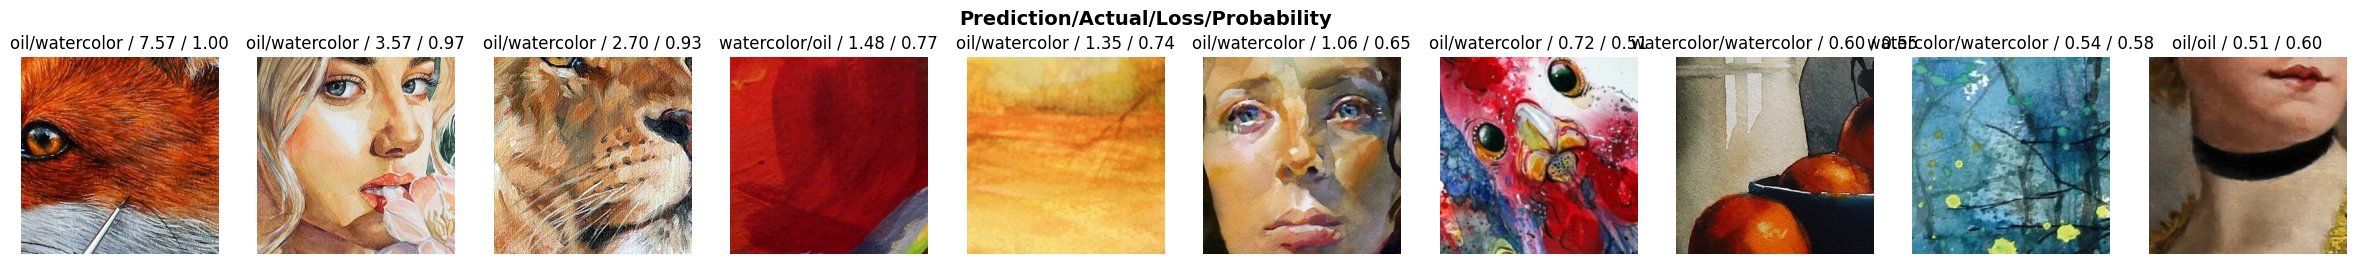

In [10]:
interp.plot_top_losses(10, nrows=1)

Check if within one ganre model performs different

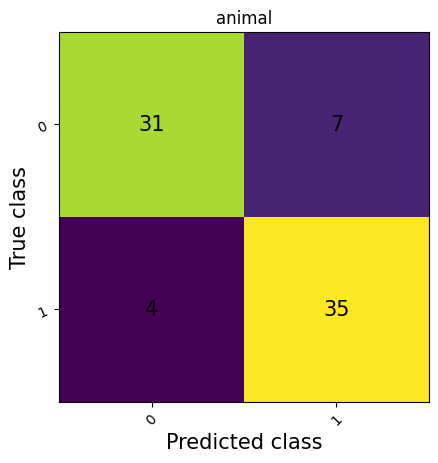

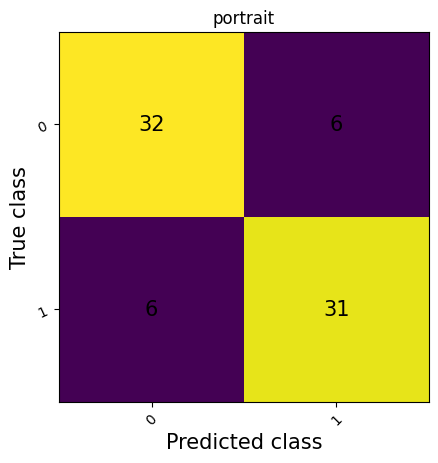

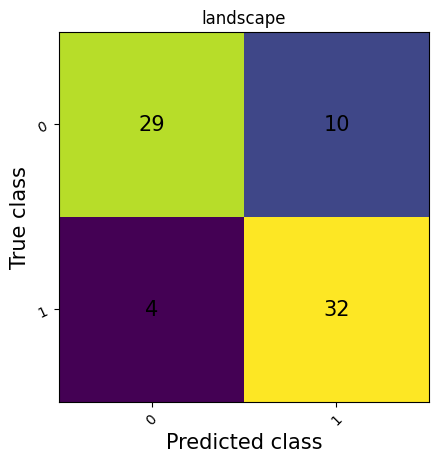

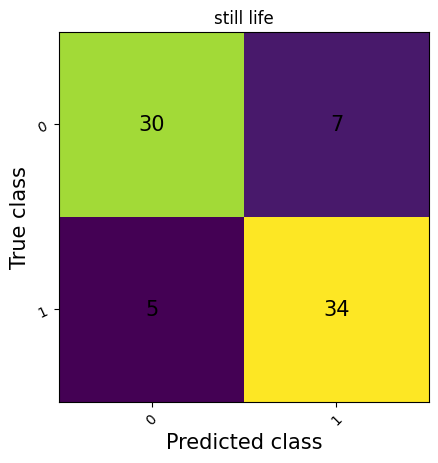

In [11]:
lbl = {"oil" : 1, "watercolor": 0}
path = Path('oil_or_watercolor')
target = []
pred = []
files = []
for g in genres:
    target_ = []
    pred_ = []
    files_ = []
    confmat = BinaryConfusionMatrix()
    dir = (path/g)
    for file in get_image_files(dir):
        im=PILImage.create(file)
        target_.append(lbl[parent_label(file)])
        with learn.no_bar():
            pred_.append(learn.predict(im)[2][0].item())
        files_.append(file)
    confmat(tensor(pred_), tensor(target_))
    fig, ax = confmat.plot()
    ax.set_title(g)
    target = target + target_
    pred = pred + pred_
    files = files + files_

Check 20 images with biggest losses and clean if labels are wrong.

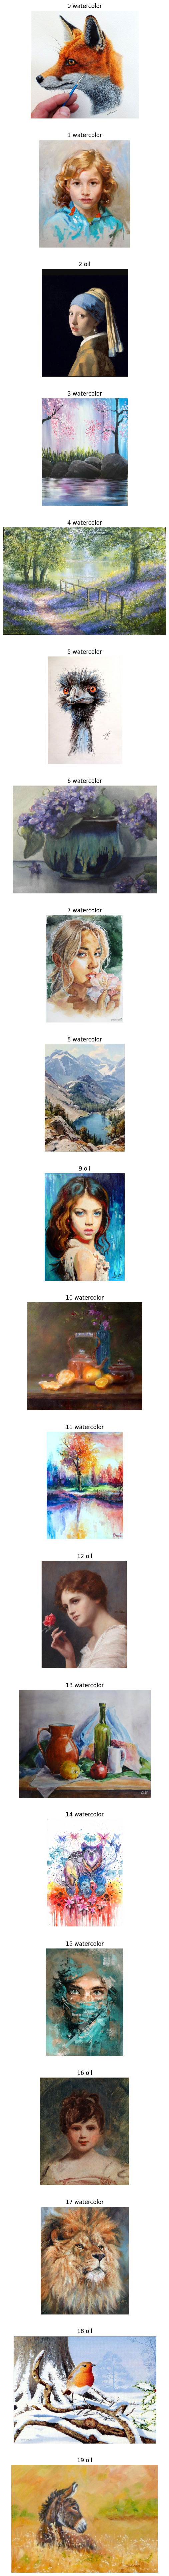

In [12]:
_,axs = subplots(20, 1,figsize=(100, 100))
fs = sorted([(abs(t-p),f) for (t,p,f) in zip(target,pred,files)],reverse=True)[:20]
nfs = list(enumerate(map(lambda x: x[1], fs)))

def remove(nfiles):    
    for _,fname in filter(lambda x: x[0] in nfiles,nfs):
        print(f'{fname} removed')
        os.remove(fname)
        
for ax,(i,file) in zip(axs.flatten(),nfs):
    im=PILImage.create(file)
    im.show(ax,title=f"{i} {parent_label(file)}")

In [13]:
nums = input("numbers of images to delete: ")
remove(list(map(int, nums.split())))

numbers of images to delete:  0 1 3 8 10 15 17


oil_or_watercolor/animal/watercolor/54e5f9e8-d168-4182-86a3-cf74198b424a.jpg removed
oil_or_watercolor/portrait/watercolor/8a4631d6-8368-4ba8-a273-9971a00448fa.jpg removed
oil_or_watercolor/landscape/watercolor/c72740e5-15ed-4927-9cd9-078ba213ff23.jpg removed
oil_or_watercolor/landscape/watercolor/1721f142-a27c-4338-8fea-383e01d904b7.jpg removed
oil_or_watercolor/still life/watercolor/5c5ad6d3-7c5c-4e65-8f3c-66455ead3553.jpg removed
oil_or_watercolor/portrait/watercolor/8aca6046-1003-4e74-99ea-46b8c385d0f7.jpg removed
oil_or_watercolor/animal/watercolor/183f82f1-dd7b-4a20-b369-eb5db2b423b0.jpg removed


In [42]:
from torchmetrics.classification import BinaryAccuracy
def test_accuracy(learner):
    path = Path('test')
    target = []
    pred = []
    for file in get_image_files(path):
        im=PILImage.create(file)
        target.append(lbl[parent_label(file)])
        with learner.no_bar():
            pred.append(learner.predict(im)[2][0].item())
    metric = BinaryAccuracy()
    return metric(tensor(pred), tensor(target)).item()

In [15]:
path = Path('oil_or_watercolor')
dls = DataBlock(
    blocks=(ImageBlock, CategoryBlock), 
    get_items=get_image_files, 
    splitter=RandomSplitter(valid_pct=0.2),
    get_y=parent_label,
    item_tfms=RandomCrop(300)
).dataloaders(path, bs=32)

# Fit bigger NNs

In [47]:
learn34 = vision_learner(dls, resnet34, metrics=error_rate)
learn34.fine_tune(3)

In [48]:
learn_sq = vision_learner(dls, squeezenet1_1, metrics=error_rate)
learn_sq.fine_tune(3)

In [49]:
learn_dn = vision_learner(dls, densenet201, metrics=error_rate)
learn_dn.fine_tune(3)

# Table with results of resnet34,  squeezenet1_1, densenet201

In [51]:
df = pd.DataFrame(columns=['NN','train_loss','valid_loss','error_rate','test_accuracy'])
df = df.set_index('NN')
df.loc['resnet34'] = list(learn34.final_record) + [test_accuracy(learn34)]
df.loc['squeezenet1_1'] = list(learn_sq.final_record) + [test_accuracy(learn_sq)]
df.loc['densenet201'] = list(learn_dn.final_record) + [test_accuracy(learn_dn)]

In [52]:
df

train_loss  valid_loss  error_rate  test_accuracy
NN                                                              
resnet34         0.580194    0.705075    0.220339       0.750000
squeezenet1_1    0.677320    0.556865    0.288136       0.802632
densenet201      0.519747    0.416480    0.118644       0.828947

In [53]:
learn34.export('rn34.pkl')
learn_sq.export('sq.pkl')
learn_dn.export('dn201.pkl')

In [54]:
from IPython.display import FileLink

FileLink('dn201.pkl')

/kaggle/working/dn201.pkl